## $I = a(1-e^\frac{-t}{b})$
### gas sensor response
---
C : State `state_mtx` - matrix showing the activity of a cell for giving current carrier (1:active, 0:deactivated)

G : Gas Mixture `mixture_mtx` - matrix showing the probability of interaction between sensing material and target gas

T : Time [s] `time_mtx` - local time matrix for each cell

M : Molecular Weight [g/mol] `molweight_mtx` - matrix of molar weight

L : Distance [m] `distance_mtx` - matrix of a random distance between sensing material and target gas that will be sensed

`ppm` : the concentration of target gas in gas mixture

`q_e` : electric charge of an electron

`epsilon` : Minimum distance between sensing material and target gas (the gas that will be sensed)

`T` : Temperature in Kelvin

In [6]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numba
import numpy as np
from rich.progress import Progress

In [7]:
K_B = 1.380649e-23
R = 8.314
Q_E = 1.6021e-19
NA = 6.0221409e23
PI = np.pi

In [8]:
@numba.jit
def maxwell_boltzmann_distribution(v, temperature, molecule_mass):
    t = temperature
    m = molecule_mass
    expr1 = 4 * PI * (v ** 2)
    expr2 = (m / (2 * PI * K_B * t)) ** 1.5
    expr3 = np.exp((-m * (v ** 2)) / (2 * K_B * t))
    return expr1 * expr2 * expr3


@numba.jit
def sample_maxwell_boltzmann(temperature, molar_mass):
    molecule_mass = molar_mass / NA
    mean = np.sqrt((2 * R * temperature) / molar_mass)
    v = np.linspace(0, 3 * mean, 100)
    pd = maxwell_boltzmann_distribution(v, temperature, molecule_mass)
    return v, ((1 / pd.sum()) * pd)

In [9]:
class NanoWire:
    def __init__(self, width, length, n_x, n_y, surface_carrier_density):
        self.width = width
        self.length = length
        self.n_x = n_x
        self.n_y = n_y
        self.surface_carrier_density = surface_carrier_density

    @property
    def grid_size(self):
        return (self.n_x, self.n_y)

    @property
    def cell_carriers(self):
        num = self.surface_carrier_density * self.length * self.width
        den = self.n_x * self.n_y
        return int(num / den)

In [10]:
class Environment:
    def __init__(
        self,
        concentration,
        temperature,
        pressure,
        max_distance,
        active_gas_molweight,
        passive_gas_molweight,
        active_gas_diameter,
        passive_gas_diameter,
    ):
        self.concentration = concentration
        self.temperature = temperature
        self.pressure = pressure
        self.max_distance = max_distance
        self.active_gas_molweight = active_gas_molweight
        self.passive_gas_molweight = passive_gas_molweight
        self.active_gas_diameter = active_gas_diameter
        self.passive_gas_diameter = passive_gas_diameter

In [11]:
class GasSensorSimulation:
    def __init__(
        self,
        nanowire: NanoWire,
        environment: Environment,
        constant_concentration: bool,
    ):
        self.nanowire = nanowire
        self.environment = environment

        self.constant_concentration = constant_concentration
        self.state_mtx = np.ones(self.nanowire.grid_size, dtype=np.bool_)
        self.time_mtx = np.zeros(self.nanowire.grid_size)
        self.iterations = 0

    def get_gasses_probabilities(self):
        p_active_gas = self.environment.concentration
        p_passive_gas = 1 - (self.environment.concentration)
        return p_passive_gas, p_active_gas

    def get_mixture_mtx(self):
        binary_values = np.array([True, False], dtype=np.bool_)
        p = self.get_gasses_probabilities()
        return np.random.choice(binary_values, self.nanowire.grid_size, p=p)

    def update_time_mtx(self, mixture_mtx):
#         d_p = self.environment.passive_gas_diameter
#         d_a = self.environment.active_gas_diameter
#         t_env = self.environment.temperature
#         p_env = self.environment.pressure
#         m_p = self.environment.passive_gas_molweight
#         m_a = self.environment.active_gas_molweight
#         d_mtx = d_p * mixture_mtx - d_a * (mixture_mtx - 1)
#         mfp_mtx = (R * self.environment.temperature) / (
#             np.sqrt(2) * PI * np.square(d_mtx) * NA * self.environment.pressure
#         )

        #         molweight_mtx = m_p * mixture_mtx - m_a * (mixture_mtx - 1)
        v_active, p_active = sample_maxwell_boltzmann(
            self.environment.temperature, self.environment.active_gas_molweight
        )
        v_active_mtx = np.random.choice(v_active, self.nanowire.grid_size, p=p_active)
        v_passive, p_passive = sample_maxwell_boltzmann(
            self.environment.temperature, self.environment.passive_gas_molweight
        )
        v_passive_mtx = np.random.choice(
            v_passive, self.nanowire.grid_size, p=p_passive
        )
        v_mtx = np.where(mixture_mtx == 0, v_active_mtx, v_passive_mtx)
        mfp_mtx = (
            np.random.rand(*self.nanowire.grid_size) * self.environment.max_distance
        )
        self.time_mtx += (mfp_mtx / v_mtx) * self.state_mtx

    @property
    def active_cell_ratio(self):
        total_cells = self.nanowire.n_x * self.nanowire.n_y
        active_cells = self.state_mtx.sum()
        active_ratio = active_cells / total_cells
        return active_ratio

    def is_converged(self, active_cell_ratio_to_converge):
        return self.active_cell_ratio < active_cell_ratio_to_converge

    def run(self, active_cell_ratio_to_converge):
        total_remained = self.active_cell_ratio - active_cell_ratio_to_converge
        with Progress() as progress:
            task = progress.add_task("[red]Solving...", total=100)
            while not self.is_converged(active_cell_ratio_to_converge):
                mixture_mtx = self.get_mixture_mtx()
                self.state_mtx *= mixture_mtx
                self.update_time_mtx(mixture_mtx)
                self.iterations += 1
                self.simulation_time = (self.time_mtx * -1 * (self.state_mtx - 1)).max()
                remained = self.active_cell_ratio - active_cell_ratio_to_converge
                advance = int((total_remained - remained) * 100 / total_remained)
                description_parts = [
                    f"ACR: {self.active_cell_ratio:.2e}",
                    f"ITR: {self.iterations:07}",
                ]
                description = "{" + ", ".join(description_parts) + "}"
                progress.update(task, completed=advance, description=description)
            progress.update(task, completed=100)

    def get_time_current_array(self):
        flat_time_mtx = np.unique(self.time_mtx.flatten())
        time_list = []
        current_list = []
        for t in flat_time_mtx:
            step_state = np.where(self.time_mtx <= t, self.state_mtx, 1)
            n_e = (self.nanowire.n_y * self.nanowire.n_x) - step_state.sum()
            current = n_e * Q_E * self.nanowire.cell_carriers
            time_list.append(t)
            current_list.append(current)
        return np.array(time_list), np.array(current_list)


#         print(f"Convergened @ {self.iterations} iteration")

In [12]:
concentration = 10e-6
n_x = 100
n_y = 100
max_distance = 0.5  # m
length = 0.5e-2  # m
width = 5e-6  # m
active_gas_molweight = 1.00794 * 2e-3  # kg/mol H2
passive_gas_molweight = 28.97e-3  # kg/mol
tio2_surface_area = 34.1e-20
surface_carrier_density = 1 / tio2_surface_area
passive_gas_diameter = (0.299 * 0.21 + 0.305 * 0.78 + 0.01 * 0.363) * 1e-9
active_gas_diameter = 289e-12 * 2  # H2
temperature = 300
pressure = 101325

In [13]:
nanowire = NanoWire(width, length, n_x, n_y, surface_carrier_density)
environment = Environment(
    concentration,
    temperature,
    pressure,
    max_distance,
    active_gas_molweight,
    passive_gas_molweight,
    active_gas_diameter,
    passive_gas_diameter,
)
simulation = GasSensorSimulation(nanowire, environment, constant_concentration=True)

In [14]:
simulation.run(0.01)

{ACR: 5.29e-02, ITR: 0286927} ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━  95% -:--:--

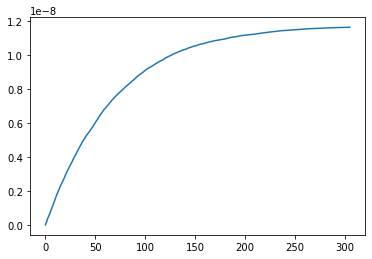

In [15]:
plt.plot(*simulation.get_time_current_array())

In [16]:
r = np.random.rand(n_x, n_y) * max_distance

In [17]:
r.mean()

0.24835557087939478